In [1]:
# you may have to install some packages before this runs 
# - consider setting up a conda environment!

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(f"Running on {device}")

Running on cuda


In [20]:
# This cell is setting up some functions you will need later.
# You don't need to understand everything here (or change anything here). 
# Some functionalities are actually not needed for this exercise.

# But the following you should be able to answer in words or sketches / equations:
# (a) Why does the structure of the fully connected NN we are setting up in the 
#     PowNet class match the problem at hand?
#     What motivates the choice of activation function and cost function, 
#     and the initialization of weights? 
# (b) What choices are made in the proposed training scheme (first_attempt_at_training)?

data_type = torch.float
data_type_c = np.cdouble

N_grid = 4096 # size of 1D data grid
N_grid_half = int(N_grid/2+0.5)
k_max = 3.0
dk = 2*k_max/N_grid
k_min = -k_max+dk

k_values = np.linspace(k_min, k_max, N_grid)
ns_low = 1.0    # primordial power spectrum index
ns_high = -1.5  # power spectrum beyond equality scale
k0 = 0.01


# a class to represent a set of data with associated true parameter values
class PowDataset(Dataset):

    def __init__(self, deltas, amplitudes):
        # deltas is an array of delta arrays, amplitudes an array of associated amplitudes
        self.data = deltas
        self.labels = amplitudes

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


class PowNet(nn.Module):
    
    # This is setting up the structure of the neural network
    def __init__(self, N_grid=N_grid):
        super(PowNet, self).__init__()

        self.N_grid = N_grid
        self.N_grid_half = int(0.5*N_grid+0.1)

        # Get cpu or gpu device for training.
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        # self.device = "cpu"
        print(f"Using {self.device} device")

        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(N_grid, N_grid)  # Fourier transform that is being squared by activation function
        self.fc2 = nn.Linear(N_grid, 1)       # "Fisher" layer projecting onto
                                              # best-fit parameter

        self.to(self.device)

    # This defines the activation function we'll use - it's quadratic near x=0
    def hyperbolic_activation(self, x):
        return torch.tanh(x)**2



    # This initializes the weights of the fully connected neural network to 
    # mirror the analytically optimal way of estimating the amplitude
    # of the power spectrum with known shape from a measurement of data
    def initialise_weights_to_power_spectrum(self, k_values, pow_fid, dpow_dA):
        #
        # Check array lengths:
        if len(k_values) != self.N_grid_half:
            print(len(k_values),len(pow_fid),len(dpow_dA))
            return np.nan
        if len(pow_fid) != self.N_grid_half:
            print(len(k_values),len(pow_fid),len(dpow_dA))
            return np.nan
        if len(dpow_dA) != self.N_grid_half:
            print(len(k_values),len(pow_fid),len(dpow_dA))
            return np.nan

        # Small number to impove the way in which the hyperbolic activation function
        # approximates "squaring"
        #
        rescale = 0.001 # if this is factor 10 higher, variance ends up a few % higher; if factor 10 lower, almost nothing happens
        #
        # Fast Fourier Transform in the form of weights of our fully connected layers
        k_np = np.array(k_values)
        dk = k_np[1]-k_np[0]
        x_max = 2.0*np.pi/dk
        dx = x_max/self.N_grid
        x_np = np.linspace(0.0, x_max-dx, self.N_grid)
        prefactor = 0.5*np.sqrt(2.0/np.pi)*x_max/self.N_grid
        xk = np.outer(x_np, k_np)
        F_mat = np.zeros((self.N_grid,self.N_grid))
        F_mat[:,:self.N_grid_half] = np.cos(xk)
        F_mat[:,self.N_grid_half:] = np.sin(xk)
        F_mat = np.transpose(F_mat)
        F_mat = torch.tensor(F_mat*prefactor*rescale, dtype=data_type).to(self.device)
        #
        self.fc1.weight = nn.Parameter(F_mat)
        self.fc1.bias = None
        
        # Projecting the square of the real part of FT into power spectrum amplitude:
        #
        pow_np = np.array(pow_fid)
        dpow_dA_np = np.array(dpow_dA)
        indxs_nonzero = np.where(pow_np**2!=0.0)[0]
        Fisher = np.sum(dpow_dA_np[indxs_nonzero]**2/pow_np[indxs_nonzero]**2)
        projection = np.zeros(self.N_grid_half)
        projection[indxs_nonzero] = dpow_dA_np[indxs_nonzero]/pow_np[indxs_nonzero]**2/Fisher
        #
        # Now doubling this projection to include imaginary part:
        #
        projection_double = np.zeros((1,self.N_grid))
        projection_double[0,:self.N_grid_half] = projection
        projection_double[0,self.N_grid_half:] = projection
        projection_double = torch.tensor(projection_double/rescale**2, dtype=data_type).to(self.device)
        #
        self.fc2.weight = nn.Parameter(projection_double)
        self.fc2.bias = None
    
    
    # function that propagates data through the network
    def forward(self, x):
        x = self.fc1(x)

        x = self.hyperbolic_activation(x) # activation function that can
                                          # approximate square function
        x = self.fc2(x)

        return x

    
    # function that trains network given a dataloader that handles training data
    def do_train(self, dataloader, loss_fn, optimizer):
        size = len(dataloader.dataset)
        self.train() # tell model we are going to train (not evaluate), which may have different behavior (dropouts etc)
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(self.device), y.to(self.device)

            # Compute prediction error
            pred = self(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % 1 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

                
    # function that evaluates performance on some test data
    def do_test(self, dataloader, loss_fn):
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        self.eval() # tell model we are going to evaluate (not train), which may have different behavior (dropouts etc)
        test_loss, correct = 0, 0
        with torch.no_grad():
            for batch, (X, y) in enumerate(dataloader):
                X, y = X.to(self.device), y.to(self.device)
                pred = self(X)
                test_loss += loss_fn(pred, y).item()
        test_loss /= num_batches
        print(f"Avg loss: {test_loss:>8f} \n")


        
class FirstNet(nn.Module):
    #
    def __init__(self, N_grid=N_grid):
        super(FirstNet, self).__init__()
        
        # Get cpu or gpu device for training.
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using {self.device} device")

        self.N_grid = N_grid
        self.conv_width = int(N_grid/20.0+0.1)
        # 1 input image channel, 6 output channels, N_grid/20 convolution width
        self.conv1 = nn.Conv1d(1, 6, self.conv_width).to(self.device)
        self.conv2 = nn.Conv1d(6, 12, self.conv_width).to(self.device)
        self.conv3 = nn.Conv1d(12, 18, self.conv_width).to(self.device)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(18 * self.conv_width, 120).to(self.device)
        self.fc2 = nn.Linear(120, 84).to(self.device)
        self.fc3 = nn.Linear(84, 10).to(self.device)
        self.fc4 = nn.Linear(84, 1).to(self.device)

        # # Get cpu or gpu device for training.
        # self.device = "cuda" if torch.cuda.is_available() else "cpu"
        # print(f"Using {self.device} device")

    #
    def forward(self, x):
        # Max pooling over a width-2 window
        #x = x.view(1,len(x),-1) # put in channel format even though there is only one channel
        #print(x.shape)
        x = F.max_pool1d(F.relu(self.conv1(x)), 2)
        x = F.max_pool1d(F.relu(self.conv2(x)), 2)
        x = F.max_pool1d(F.relu(self.conv3(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    def do_train(self, dataloader, loss_fn, optimizer):
        size = len(dataloader.dataset)
        self.train() # tell model we are going to train (not evaluate), which may have different behavior (dropouts etc)
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(self.device), y.to(self.device)
            print("Train: ", X.shape, y.shape)

            # Compute prediction error
            pred = self(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % 1 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


    def do_test(self, dataloader, loss_fn):
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        self.eval() # tell model we are going to evaluate (not train), which may have different behavior (dropouts etc)
        test_loss, correct = 0, 0
        with torch.no_grad():
            for batch, (X, y) in enumerate(dataloader):
                X, y = X.to(self.device), y.to(self.device)
                print("Test: ", X.shape, y.shape)
                pred = self(X)
                test_loss += loss_fn(pred, y).item()
        test_loss /= num_batches
        print(f"Avg loss: {test_loss:>8f} \n")


def power_spectrum_broken_power_law(k, amplitude=1, k0=k0, ns_high=ns_high, ns_low=ns_low):
    k_abs = np.abs(k)
    return amplitude*(k_abs/k0)**ns_low/(1.0 + (k_abs/k0)**(-ns_high+ns_low))

def power_spectrum_one_k(k, k_non_zero):
    pk = np.zeros(k.shape)
    bingo ,= np.where(np.abs(k)==np.abs(k_non_zero))
    pk[bingo] = 1
    return pk

def predict_one_point_variance(powerspectrum, only_positive_k=True, dk=dk):
    variance_1_point = np.sum(powerspectrum[1:])
    if(only_positive_k): # if the power spectrum only goes from 0 to kmax
        variance_1_point *= 2
    variance_1_point += powerspectrum[0]
    variance_1_point *= dk/np.sqrt(2.0*np.pi)
    return variance_1_point

def return_fourier_transform(psi):
    return np.fft.fft(psi)*dk/np.sqrt(2.0*np.pi)

def return_fourier_backtransform(psi):
    return np.fft.ifft(psi)*np.sqrt(2.0*np.pi)/dk

def return_delta_field(seed, A):
    #
    np.random.seed(seed)
    my_power_spectrum = power_spectrum_broken_power_law(k_values[N_grid_half-1:N_grid-1], amplitude=A)
    #
    Fourier_coeffs = np.zeros(N_grid, dtype=data_type_c)
    Fourier_coeffs[0:N_grid_half] +=      np.sqrt(0.5)*np.random.normal(np.zeros(N_grid_half), np.sqrt(my_power_spectrum))
    Fourier_coeffs[0:N_grid_half] += np.sqrt(0.5)*1.0j*np.random.normal(np.zeros(N_grid_half), np.sqrt(my_power_spectrum))
    Fourier_coeffs[N_grid_half+1:] = np.flip(Fourier_coeffs[1:N_grid_half].conj())
    #
    delta = return_fourier_transform(Fourier_coeffs)
    return delta.real


def return_delta_field_one_k(seed, A=1, k=k_values[int(2*N_grid/3)]): # just for unit tests
    #
    np.random.seed(seed)
    #
    my_power_spectrum = A*power_spectrum_one_k(k_values[N_grid_half-1:N_grid-1],k)

    Fourier_coeffs = np.zeros(N_grid, dtype=data_type_c)
    Fourier_coeffs[0:N_grid_half] +=      np.sqrt(0.5)*np.random.normal(np.zeros(N_grid_half), np.sqrt(my_power_spectrum))
    Fourier_coeffs[0:N_grid_half] += np.sqrt(0.5)*1.0j*np.random.normal(np.zeros(N_grid_half), np.sqrt(my_power_spectrum))
    Fourier_coeffs[N_grid_half+1:] = np.flip(Fourier_coeffs[1:N_grid_half].conj())

    delta = return_fourier_transform(Fourier_coeffs)

    variance_1_point = np.sum(my_power_spectrum)*2 # my_power_spectrum is missing negative k, so *2
    print("sum(power spectrum)=",variance_1_point)
    variance_1_point *= (dk/np.sqrt(2.0*np.pi))**2
    print("expected variance from PS:",variance_1_point)

    return delta.real #**2 - np.sqrt(A)*9.426894994821567e-06


def estimate_powerspectrum(deltafield):
    deltatilde = return_fourier_backtransform(deltafield)
    pk = np.abs(deltatilde[1:N_grid_half])**2 # power spectrum estimate

    return pk

def ps_likelihood(powerspectrum, deltafield, amplitude=1):
    # expecting the powerspectrum to already be cut to the non-negative parts

    res = pk / (amplitude*powerspectrum)

    # res should be distributed as p(res)=2*chi2.pdf(res,df=2)
    # the second is the regularization term to punish large model power spectra
    return np.sum(np.log(2.*chi2.pdf(res,df=2))) - 0.5*np.sum(np.log(amplitude*powerspectrum))

def generate_data(n, amp=None, seed=0):
    if(amp is None):
        amp = np.random.uniform(0.5,1.5,n)

    inputs = torch.zeros((n, N_grid), dtype=data_type).to(device)

    for i in range(n):
        inputs[i] = torch.from_numpy(return_delta_field(seed+i,amp[i]))

    return PowDataset(inputs.to(device),torch.tensor(amp, dtype=data_type).view(-1,1).to(device))


# This is a first attempt at a training routine. You may want to re-implement it.

def first_attempt_at_training(niterations = 20, pownet = None, lr = 0.001, amp_min=0.5, amp_max=1.5):

    # (1) generate training and validation data

    training = generate_data(10000, amp=np.random.uniform(amp_min, amp_max, 10000))
    validation = generate_data(100, amp=np.random.uniform(amp_min, amp_max, 100), seed=50000)

    # (2) set up pownet

    if(pownet is None):
        pownet = PowNet()
    criterion = myCustomLoss 

    # create your optimizer
    optimizer = optim.Adam(pownet.parameters(), lr=lr)

    # (3) train
    # this one iterates using data loader

    training_loader  = DataLoader(training, batch_size=1000, shuffle=True)
    validation_loader = DataLoader(validation, batch_size=10, shuffle=False)

    for i in range(niterations):

        print(f"Epoch {i+1}\n-------------------------------")
        pownet.do_train(training_loader, criterion, optimizer)
        pownet.do_test(validation_loader, criterion)

    return pownet


# use relative error, squared, as loss
def myCustomLoss(my_outputs, my_labels):
    loss = ((my_outputs-my_labels)/my_labels)**2
    return torch.mean(loss)

# make some plots and print some numbers to evaluate performance on data
def evaluation_plots(dataset,pownet):
    

    loader = DataLoader(dataset, batch_size=10, shuffle=False)
    criterion = myCustomLoss #nn.MSELoss()
    pownet.do_test(loader, criterion)

    estimates = torch.zeros(len(dataset.data), dtype=data_type)
    for j in range(len(dataset.data)):
            estimates[j] = pownet(dataset.data[j])

    plt.figure()
    plt.plot(estimates.detach().cpu().numpy())
    
    plt.ylabel("amplitude")
    plt.xlabel("id")
    plt.figure()
    plt.scatter(estimates.detach().cpu().numpy(), dataset.labels.detach().cpu().numpy())
    plt.xlabel("estimated amplitudes")
    plt.ylabel("true amplitudes")
    plt.plot((0,100),(0.,100), color='orange')
    plt.figure()
    plt.hist(estimates.detach().cpu().numpy(),bins=np.arange(-20,120),label="estimated", alpha=0.5)
    plt.hist(dataset.labels.detach().cpu().numpy(),bins=np.arange(-20,120),label="true", alpha=0.5)
    plt.legend()
    plt.xlabel("amplitude")
    plt.ylabel("count")


k_vals = k_values[N_grid_half:]
P_values = power_spectrum_broken_power_law(k_vals)
P_2 = power_spectrum_broken_power_law(k_vals, amplitude=2)

k_vals = torch.tensor(k_vals, dtype=torch.float)
P_values = torch.tensor(P_values, dtype=torch.float)



In [21]:
print(k_values[:])
print(k_values[N_grid_half:])
print(k_vals)

[-2.99853516 -2.99707031 -2.99560547 ...  2.99707031  2.99853516
  3.        ]
[1.46484375e-03 2.92968750e-03 4.39453125e-03 ... 2.99707031e+00
 2.99853516e+00 3.00000000e+00]
tensor([1.4648e-03, 2.9297e-03, 4.3945e-03,  ..., 2.9971e+00, 2.9985e+00,
        3.0000e+00])


3.0
-2.99853515625
0.00146484375
4095.0
(4096,)
torch.Size([2048])
torch.Size([2048])


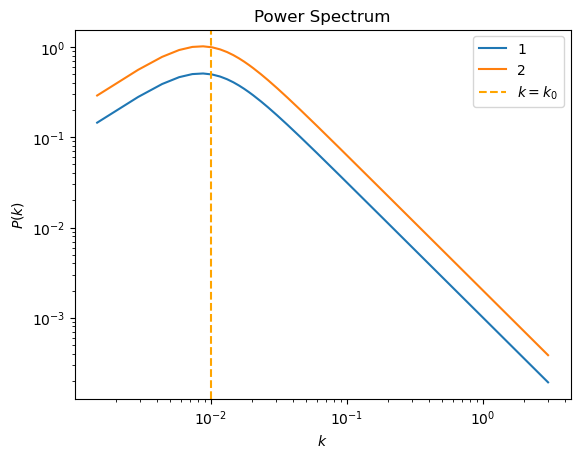

In [23]:
print(k_max)
print(k_min)
print(dk)
print((k_max-k_min)/dk)
print(k_values.shape)
print(k_vals.shape)
print(P_values.shape)
plt.plot(k_vals, P_values, label="1")
plt.plot(k_vals, P_2, label="2")
plt.axvline(k0, color="orange", linestyle="--", label=r"$k=k_0$")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$k$")
plt.ylabel(r"$P\left(k\right)$")
plt.title("Power Spectrum");

[ 0.        +0.j         -0.08073108-0.00228368j -0.08611796-0.51569844j
 ...  0.1206138 +0.08631545j -0.08611796+0.51569844j
 -0.08073108+0.00228368j]
[ 1.08670750e-03  1.58038103e-04  1.13766276e-03 ... -5.44722698e-04
  2.50153296e-04  8.19275599e-06]


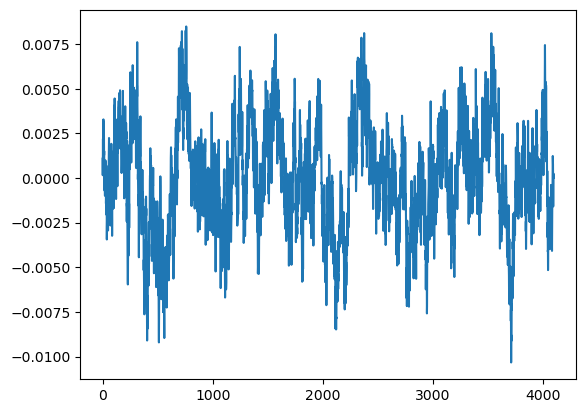

In [6]:
my_power_spectrum = power_spectrum_broken_power_law(k_values[N_grid_half-1:N_grid-1], amplitude=1)
Fourier_coeffs = np.zeros(N_grid, dtype=data_type_c)
# print(Fourier_coeffs)
Fourier_coeffs[0:N_grid_half] +=      np.sqrt(0.5)*np.random.normal(np.zeros(N_grid_half), np.sqrt(my_power_spectrum))
# print(Fourier_coeffs)
Fourier_coeffs[0:N_grid_half] += np.sqrt(0.5)*1.0j*np.random.normal(np.zeros(N_grid_half), np.sqrt(my_power_spectrum))
# print(Fourier_coeffs)
Fourier_coeffs[N_grid_half+1:] = np.flip(Fourier_coeffs[1:N_grid_half].conj())
delta = return_fourier_transform(Fourier_coeffs)
print(Fourier_coeffs)
print(delta.real)
# print(delta.real.shape)
plt.plot(np.arange(len(delta)), delta.real)

In [29]:
# generate some test data
test=generate_data(1000,amp=np.random.uniform(0.1,100,1000), seed=30000)

# (b) Plot a few entries in the test data and note their amplitudes in the plot. 
# CODE TODO HERE
print(test[0])
print(test[1])

# for i in range(4):
#     plt.plot(k_values, test[i][0], label = f"$A={test[i][1][0]:.2f}$")
#     plt.xlabel("$k$")
#     plt.legend()
#     plt.show()
#     plt.clf()
print(test[:, 0])

(tensor([-0.0282, -0.0177, -0.0050,  ..., -0.0301, -0.0220, -0.0263],
       device='cuda:0'), tensor([51.9627], device='cuda:0'))
(tensor([ 0.0028,  0.0105,  0.0012,  ..., -0.0045, -0.0009,  0.0006],
       device='cuda:0'), tensor([38.0610], device='cuda:0'))
(tensor([-2.8249e-02,  2.8494e-03,  1.2399e-03, -1.2957e-04,  6.4177e-04,
         1.9774e-02,  2.7654e-02, -7.8188e-03, -2.9159e-02,  3.0411e-02,
         7.8506e-04,  1.9450e-02, -1.1882e-03,  2.7897e-02,  3.9801e-03,
        -2.8220e-02,  5.1607e-03,  8.3004e-03,  1.2195e-02,  1.5354e-02,
         1.6550e-02,  1.7815e-02, -1.5682e-02, -3.5411e-02, -3.5645e-02,
         1.0685e-04, -1.4607e-02, -8.8719e-03,  1.7636e-02, -1.0679e-02,
        -1.4534e-02, -3.6161e-02,  4.2820e-03,  5.3932e-04,  7.7582e-03,
         3.2360e-02,  2.2681e-02,  3.2402e-02, -5.6270e-02, -8.3406e-03,
        -1.1841e-02, -5.6774e-03,  5.1745e-03, -1.6057e-02, -1.9559e-02,
         7.4865e-03, -4.0787e-03,  3.1418e-03,  4.0869e-03, -3.4144e-04,
       

Using cuda device
4096
Avg loss: 0.000478 



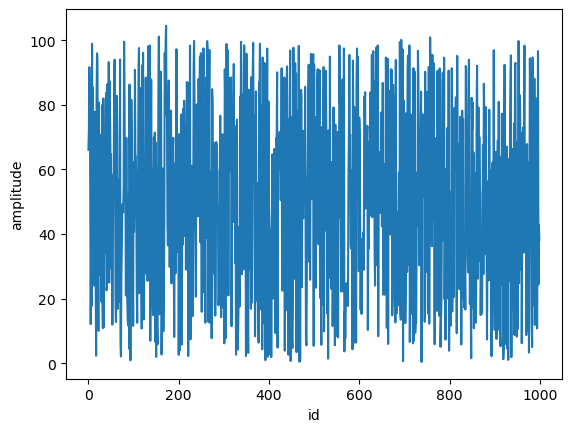

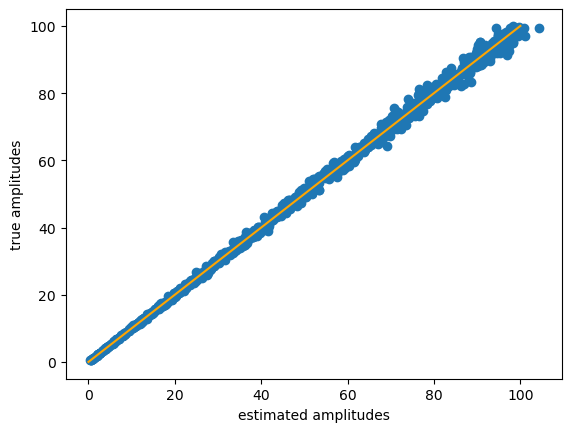

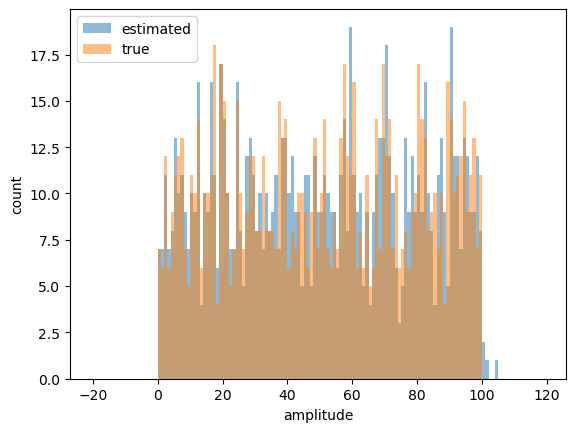

In [8]:
# evaluate performance of 'optimal' estimator of power spectrum amplitude

# initialize the simple fully connected neural network
pownet_optimal = PowNet()
print(pownet_optimal.N_grid)

# set its weights to reflect the optimal estimator of power spectrum amplitude: 
# FFT + square + matched filter
pownet_optimal.initialise_weights_to_power_spectrum(k_vals, P_values, P_values)
# print(pownet_optimal.fc2.weight)
# make some evaluation plots and also output average loss
evaluation_plots(test,pownet_optimal)
# print(torch.tensor([1]).to(device))

In [9]:
print(test.data.shape)
print(len(test.data))

torch.Size([1000, 4096])
1000


In [10]:
# forget about the optimal weights and try to learn them from the data 
pownet = None
pownet = first_attempt_at_training(15,pownet,lr=0.01,amp_min=0.1,amp_max=100)

# (c) Describe the degree of success in this first attempt of training, also including the
#     numbers and plots below in comparison to the "optimal" result above.


Using cuda device
Epoch 1
-------------------------------
loss: 1.001380  [    0/10000]
loss: 0.993224  [ 1000/10000]
loss: 0.955680  [ 2000/10000]
loss: 0.864481  [ 3000/10000]
loss: 0.696618  [ 4000/10000]
loss: 0.462590  [ 5000/10000]
loss: 0.292228  [ 6000/10000]
loss: 0.124822  [ 7000/10000]
loss: 0.217919  [ 8000/10000]
loss: 0.393590  [ 9000/10000]
Avg loss: 0.350759 

Epoch 2
-------------------------------
loss: 0.297823  [    0/10000]
loss: 0.162908  [ 1000/10000]
loss: 0.085019  [ 2000/10000]
loss: 0.103423  [ 3000/10000]
loss: 0.130975  [ 4000/10000]
loss: 0.161002  [ 5000/10000]
loss: 0.162550  [ 6000/10000]
loss: 0.156144  [ 7000/10000]
loss: 0.129785  [ 8000/10000]
loss: 0.101488  [ 9000/10000]
Avg loss: 0.109061 

Epoch 3
-------------------------------
loss: 0.080806  [    0/10000]
loss: 0.080216  [ 1000/10000]
loss: 0.107221  [ 2000/10000]
loss: 0.105684  [ 3000/10000]
loss: 0.121129  [ 4000/10000]
loss: 0.106751  [ 5000/10000]
loss: 0.083121  [ 6000/10000]
loss: 0.07

Avg loss: 0.040630 



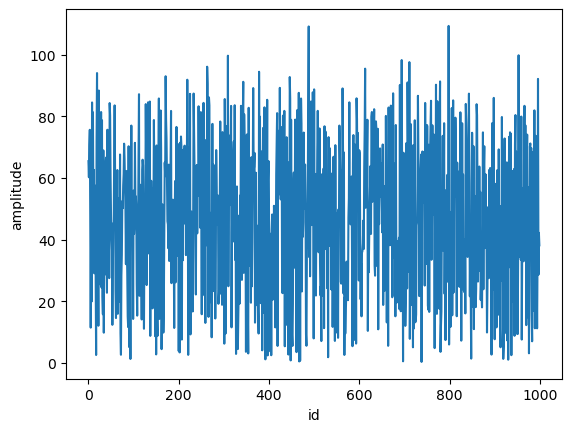

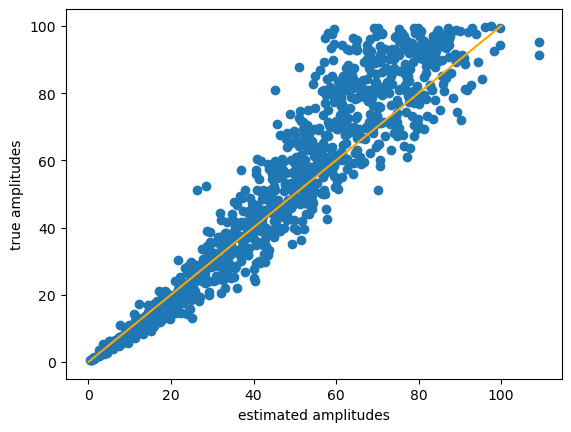

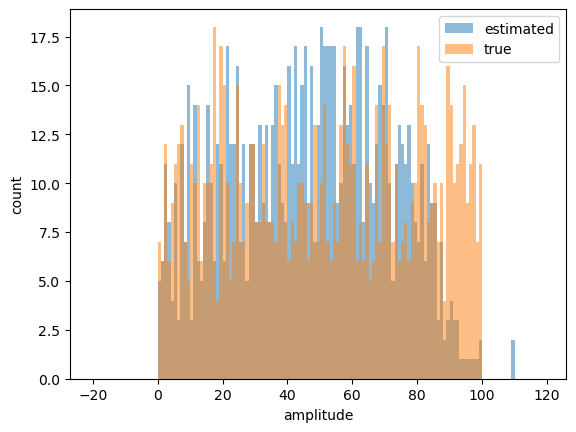

In [11]:
evaluation_plots(test,pownet)

In [12]:
# (d) Perhaps we made some poor choices. Try to change some of them ("hyperparameters") 
#     and see how this perhaps improves the training outcome.

# TODO code here

pownet_trial = None
pownet_trial = first_attempt_at_training(100,pownet_trial,lr=0.001,amp_min=0.1,amp_max=100)

Using cuda device
Epoch 1
-------------------------------
loss: 0.998975  [    0/10000]
loss: 0.998651  [ 1000/10000]
loss: 0.998161  [ 2000/10000]
loss: 0.997648  [ 3000/10000]
loss: 0.997096  [ 4000/10000]
loss: 0.996480  [ 5000/10000]
loss: 0.995243  [ 6000/10000]
loss: 0.993477  [ 7000/10000]
loss: 0.992153  [ 8000/10000]
loss: 0.990176  [ 9000/10000]
Avg loss: 0.988657 

Epoch 2
-------------------------------
loss: 0.987579  [    0/10000]
loss: 0.985459  [ 1000/10000]
loss: 0.981374  [ 2000/10000]
loss: 0.975519  [ 3000/10000]
loss: 0.969716  [ 4000/10000]
loss: 0.963980  [ 5000/10000]
loss: 0.958957  [ 6000/10000]
loss: 0.953046  [ 7000/10000]
loss: 0.941685  [ 8000/10000]
loss: 0.935325  [ 9000/10000]
Avg loss: 0.923615 

Epoch 3
-------------------------------
loss: 0.922082  [    0/10000]
loss: 0.907937  [ 1000/10000]
loss: 0.896487  [ 2000/10000]
loss: 0.884439  [ 3000/10000]
loss: 0.860301  [ 4000/10000]
loss: 0.843974  [ 5000/10000]
loss: 0.828611  [ 6000/10000]
loss: 0.80

Avg loss: 0.039592 



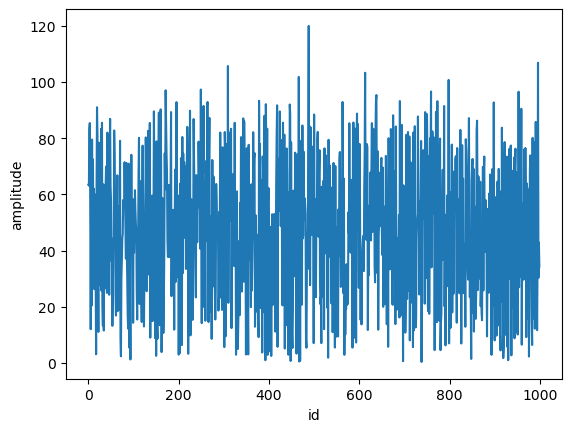

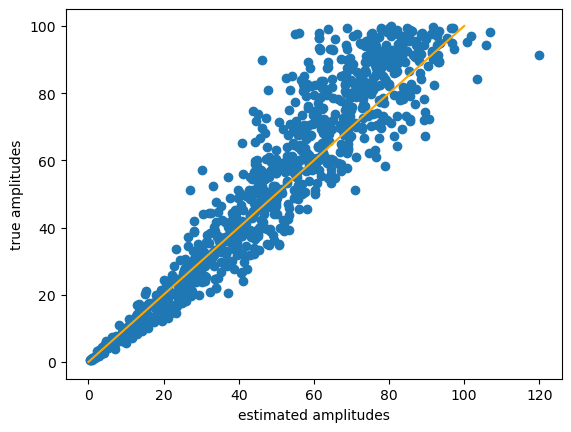

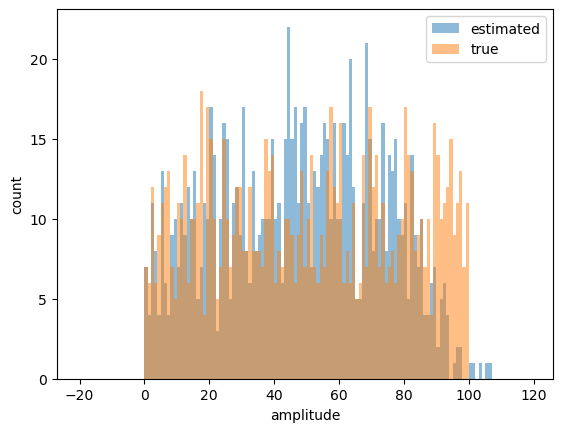

In [13]:
evaluation_plots(test,pownet_trial)

In [14]:
# (e) What happens when you continue to train the model whose weights are already set to
#     the optimal configuration (FFT + square + matched filter) before training?
#     Again, see whether changes to the training routine could improve the outcome.

pownet_headstart = first_attempt_at_training(10, pownet_optimal,
                                             lr=1.0e-6, # use a very small learning rate
                                             amp_min=0.1,amp_max=100)

Epoch 1
-------------------------------
loss: 0.000475  [    0/10000]
loss: 0.000534  [ 1000/10000]
loss: 0.000579  [ 2000/10000]
loss: 0.000647  [ 3000/10000]
loss: 0.000784  [ 4000/10000]
loss: 0.000762  [ 5000/10000]
loss: 0.000849  [ 6000/10000]
loss: 0.000803  [ 7000/10000]
loss: 0.000748  [ 8000/10000]
loss: 0.000772  [ 9000/10000]
Avg loss: 0.001102 

Epoch 2
-------------------------------
loss: 0.000392  [    0/10000]
loss: 0.000354  [ 1000/10000]
loss: 0.000360  [ 2000/10000]
loss: 0.000386  [ 3000/10000]
loss: 0.000317  [ 4000/10000]
loss: 0.000326  [ 5000/10000]
loss: 0.000350  [ 6000/10000]
loss: 0.000435  [ 7000/10000]
loss: 0.000439  [ 8000/10000]
loss: 0.000435  [ 9000/10000]
Avg loss: 0.001891 

Epoch 3
-------------------------------
loss: 0.000212  [    0/10000]
loss: 0.000254  [ 1000/10000]
loss: 0.000257  [ 2000/10000]
loss: 0.000265  [ 3000/10000]
loss: 0.000272  [ 4000/10000]
loss: 0.000247  [ 5000/10000]
loss: 0.000287  [ 6000/10000]
loss: 0.000378  [ 7000/10000

Avg loss: 0.001140 



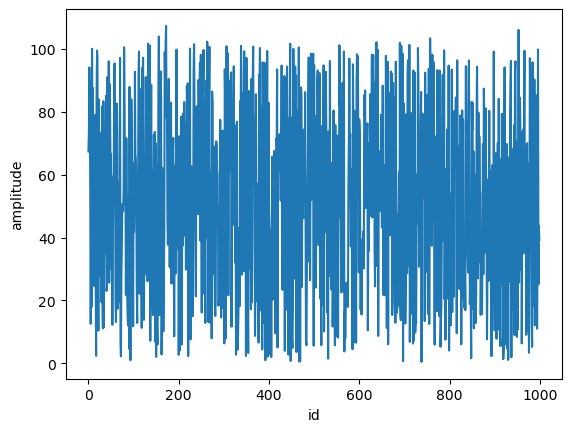

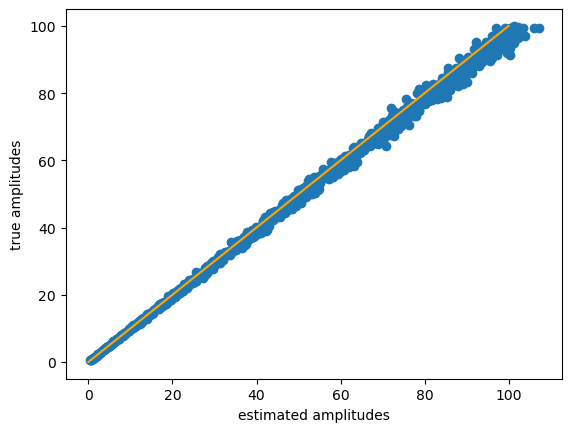

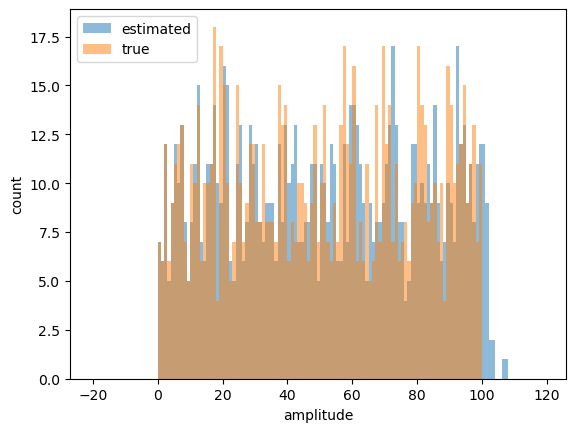

In [15]:
evaluation_plots(test,pownet_headstart)

In [16]:
# (f) Interpret your qualitative findings in the context of double descent.
# (g) Bonus: instead implement a deeper (i.e. multi-layer), convolutional neural network 
#     and apply it to the problem. How well does it perform? 
#     Better than the from-scratch trained fully connected network? 
#     Better than the algebraically initialized fully connected network?
#     Why / why not?

pownet_cnn = FirstNet()
print(pownet_cnn)



Using cuda device
FirstNet(
  (conv1): Conv1d(1, 6, kernel_size=(204,), stride=(1,))
  (conv2): Conv1d(6, 12, kernel_size=(204,), stride=(1,))
  (conv3): Conv1d(12, 18, kernel_size=(204,), stride=(1,))
  (fc1): Linear(in_features=3672, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (fc4): Linear(in_features=84, out_features=1, bias=True)
)


In [18]:
# print(pownet_cnn(test.data.reshape(1000, 1, 4096)))

In [ ]:
print(int(N_grid/20.0+0.1))

204


In [19]:
# (N_grid // 20 // 8)
# a = test.data.reshape(1000, 1, 4096) 
# print(a.shape)